### In this program we predict stats using ngrams, sentiments and ngrams and sentiments together


IMPORTING LIBRARIES 

In [1]:
import pandas as pd
from time import time
import pickle 
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from os import path
import re
import numpy as np
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics
from sys import getsizeof
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR,SVC
from sklearn.neural_network import MLPClassifier , MLPRegressor
from scipy import stats
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression


To Download files if not present in the folder

In [3]:
from os import path
if path.exists("train.csv") == False or path.exists("test.csv") == False or path.exists("lexicons") == False:
  !pip install wget
  import wget
  !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ofV_v8jEL1lewfe-rG2KDFEyQbPxVzPa' -O train.csv
  !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1sSHjl8FcHBPOAML0Kq01iSsg6t5JCNjQ' -O test.csv
  !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1P1x-sfdJ4ynzYSLACaWb2rF_CXDay-lA' -O lexicons.zip
  from zipfile import ZipFile 
  file_name = "lexicons.zip"
  # opening the zip file in READ mode 
  with ZipFile(file_name, 'r') as zip: 
      # printing all the contents of the zip file 
      zip.printdir() 
      # extracting all the files 
      print('Extracting all the files now...') 
      zip.extractall() 
      print('Done!') 
else:
  print("Files are already saved")

Files are already saved


Function to predict model where:
regressor- Classifier,Regressor used (Lasso,MLP,Decision tree)
traindata- training data 
testdata- testing data

In [4]:
def modelprid(regressor,traindata,testdata,trainres,testres,name="generic"): 
    start_time = time()
    model = regressor
    model.fit(traindata,trainres)
    if(name!="generic"):
        filename = name+".sav"
        pickle.dump(model, open(filename, 'wb'))
    sss = model.predict(testdata)
    #print("Accuracy:",metrics.accuracy_score(rte, predic))
    statis(testres,sss)

    print("\nTime = ",time() - start_time)

Open Lexicons file and save them in dictionary to use lexicons features

In [5]:
emotions = pd.read_csv("lexicons/emotion.csv",sep = "\t",error_bad_lines=False,)  
#print(emotions)  # dictionary for emoticons aggregate
emotiondic = {}
for i in range(len(emotions["word"])):
    emotiondic[emotions["word"][i]] = float(emotions["joy"][i])
#print(emotiondic)

        
# Dictionary name define itself
emoticondic = {}
emoticon = open("lexicons/emotican.txt","r")
for i in emoticon:
    tem = list(map(str,i.split()))
    emoticondic[tem[0]] = float(tem[1])
#print(emoticondic)

sent140dic = {}
sent140 = open("lexicons/sent140.txt","r")
for i in sent140:
    tem = list(map(str,i.split()))
    #print(tem)
    sent140dic[tem[0]] = [float(tem[2]), float(tem[3])]
    
    
hashsentdic = {}
hashsent = open("lexicons/hashsent.txt","r")
for i in hashsent:
    tem = list(map(str,i.split()))
    #print(tem)
    hashsentdic[tem[0]] = [float(tem[2]), float(tem[3])]

mpqadic = {}
mpqa = open("lexicons/mpqa.txt","r")
for i in mpqa:
    tem = list(map(str,i.split()))
    mpqadic[tem[0]] = tem[0]
    
bingliudic = {}
bingliu = pd.read_csv("lexicons/bingliu.csv",sep = ",",error_bad_lines=False)
#print(bingliu)
for i in range(len(bingliu["word"])):
    bingliudic[bingliu["word"][i]] = bingliu["emotion"][i]
#print(bingliudic)
    

Following are the features used to predict model

In [6]:
def enlongated(sta):        # For enlongated words
    ans = 0
    for st in sta:
        temp = re.sub(r'(.)\1+', r'\1\1', st)
        if len(temp) != len(st):
            ans += 1
    return ans
    
def wordemo(st,dic):         # Counts Emotion word count:
    if st.lower() in dic:
        return 1
    return 0

def sentiment_scores(sentence):      # Used in vader
    sid_obj = SentimentIntensityAnalyzer() 
    return sid_obj.polarity_scores(sentence)
    #print(sentiment_dict)
            
def vader(score,trainall):   # Vader returns 4 feature (positivity, neutrality, negativity, compound)
    for i in range(len(trainall)):
        temp = sentiment_scores(trainall[i])
        #print(temp)
        print("vader",i)
        score[i].append(temp["pos"])
        score[i].append(temp["neu"])
        score[i].append(temp["neg"])
        score[i].append(temp["compound"])
        
def emotionsfeat(st,dic):     #Aggregate emotion score (Hashtags)
    tem = []
    for i in st:
        if i.lower() in dic:
            tem.append(float(dic[i.lower()]))
    if tem == []:
        return 0
    return sum(tem)/len(tem)

def emoticonfeat(st,dic):  #  Emoticons score
    aa = 0
    for i in st:
        if i in dic:
            aa += dic[i]
    return aa

def sent140feat(st,dic):   #Aggregate polarity scores:
    posi = []
    neg = []
    for i in st:
        if i in dic:
            posi.append(dic[i][0])
            neg.append(dic[i][1])
    if posi == []:
        return 0,0
    return sum(posi)/len(posi) , sum(neg)/len(neg)

def hashsentfeat(st,dic):       #Aggregate polarity scores (Hashtags)
    posi = []
    neg = []
    for i in st:
        if i in dic:
            posi.append(dic[i][0])
            neg.append(dic[i][1])
    if posi == []:
        return 0,0
    return sum(posi)/len(posi) , sum(neg)/len(neg)

def mpqafeat(st,dic):            #Lexicon based Features
    posi = 0
    neg = 0
    for i in st:
        if i.lower() in dic:
            if dic[i.lower()] == "positive":
                posi += 1
            elif dic[i.lower()] == "negative":
                neg += 1
    return posi, neg

def bingliufeat(st,dic):         #Lexicon based Features
    posi = 0
    neg = 0
    for i in st:
        if i.lower() in dic:
            #print(i.lower())
            #print(dic[i.lower()])
            if dic[i.lower()] == "positive":
                posi += 1
            elif dic[i.lower()] == "negative":
                neg += 1
    return posi, neg

    

preprocess function preprocessses the data which is used to make training score matrix and test score matrix





In [7]:

def preprocess(trainall,scoretrain):
    print("Preprocessing start  ..........\n")
    print("making Score matrix")
    counter = 1
    for i in trainall:
        print(counter)
        counter += 1
        scoretrain.append([])
        temp = list(map(str,i.split()))
        #print(temp)
        scoretrain[-1].append(enlongated(temp))
        scoretrain[-1].append(emotionsfeat(temp,emotiondic))
        
        scoretrain[-1].append(emoticonfeat(temp,emoticondic))
        aaa0,aaa1 = sent140feat(temp,sent140dic)
        scoretrain[-1].append(aaa0)
        scoretrain[-1].append(aaa1)
        aaa0,aaa1 = hashsentfeat(temp,hashsentdic)
        scoretrain[-1].append(aaa0)
        scoretrain[-1].append(aaa1)
        aaa0,aaa1 = bingliufeat(temp,bingliudic)
        scoretrain[-1].append(aaa0)
        scoretrain[-1].append(aaa1)
        aaa1,aaa2 = mpqafeat(temp,mpqadic)
        scoretrain[-1].append(aaa0)
        scoretrain[-1].append(aaa1)
        
        scoretrain[-1].append(aaa0)
        scoretrain[-1].append(aaa1)
        
        
        
    vader(scoretrain,trainall)
    



For printing statistics for particular model 

In [8]:
def statis(test,pred):
    cf_matrix = confusion_matrix(test, pred)
    sns.heatmap(cf_matrix, annot=True)
    print(accuracy_score(test,pred))

    print("0 represents negative sentiment and 1 represents positive sentiment")
    confu_matrix = [[0,0],[0,0]]
    for i in range(len(test)):
        if test[i] == 1 and pred[i] == 1:
            confu_matrix[1][1] += 1
        if test[i] == 1 and pred[i] == 0:
            confu_matrix[1][0] += 1
        if test[i] == 0 and pred[i] == 1:
            confu_matrix[0][1] += 1
        if test[i] == 0 and pred[i] == 0:
            confu_matrix[0][0] += 1
    print("Confusion matrix (row represents original result and col represents predicted results :-")
    print("   0     1")
    print(0,*confu_matrix[0])
    print(1,*confu_matrix[1])
    
    tp0 = confu_matrix[0][0]
    fp0 = confu_matrix[1][0]
    fn0 = confu_matrix[0][1]
    
    tp1 = confu_matrix[1][1]
    fp1 = confu_matrix[0][1]
    fn1 = confu_matrix[1][0]
    
    print("\nFor Fake news:")
    try:
      prec0 = tp0 / (tp0 + fp0)
      recall0 = tp0 / (tp0 + fn0)
      f1s0 = 2 * (prec0 * recall0) / (prec0 + recall0)

      print("precsion =",prec0)
      print("recall = ",recall0)
      print("f1s = ",f1s0)
      
      
      print("\nFor True News:")
      prec1 = tp1 / (tp1 + fp1)
      recall1 = tp1 / (tp1 + fn1)
      f1s1 = 2 * (prec1 * recall1) / (prec1 + recall1) 
      print("precsion =",prec1)
      print("recall = ",recall1)
      print("f1s = ",f1s1)
      
      print("Aver. Precision = ",(prec0 +prec1)/2)
      print("Aver. recall = ",(recall0 + recall1)/2)
      print("Aver. f1s = ", (f1s0 + f1s1)/2)
    except:
      print("Model is highly biased")


    

In [9]:


print("Training loading ..........\n")
train1 = pd.read_csv("train.csv",index_col = False)  # open file 
train1.fillna("Nan value",inplace = True)
trainall1 = (train1["title"] +" "+ train1["author"] + " "+ train1["text"]).tolist()  # contain training sentences
trainall2 = (train1["title"] +" "+ train1["author"]).tolist()  # contain training sentences

for i in range(len(trainall1)):
  trainall1[i] = trainall1[i][:1000]   # takes ony 1000 character news(Imroves accuracy and decreases time)

result_train1 = train1["label"].tolist()   # result for training
scoretrain1 = []    # features for training data
print(train1)
print(len(trainall1))
#print(trainall)
preprocess (trainall1,scoretrain1)   # preprocessing



#for i in trainall:
print(len(scoretrain1[0]))
#    print(i)
        
        
    
     

Training loading ..........

          id                                              title  \
0          0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1          1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2          2                  Why the Truth Might Get You Fired   
3          3  15 Civilians Killed In Single US Airstrike Hav...   
4          4  Iranian woman jailed for fictional unpublished...   
...      ...                                                ...   
20795  20795  Rapper T.I.: Trump a ’Poster Child For White S...   
20796  20796  N.F.L. Playoffs: Schedule, Matchups and Odds -...   
20797  20797  Macy’s Is Said to Receive Takeover Approach by...   
20798  20798  NATO, Russia To Hold Parallel Exercises In Bal...   
20799  20799                          What Keeps the F-35 Alive   

                                          author  \
0                                  Darrell Lucus   
1                                Daniel J. Flynn   
2         

1394
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438
1439
1440
1441
1442
1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593


3163
3164
3165
3166
3167
3168
3169
3170
3171
3172
3173
3174
3175
3176
3177
3178
3179
3180
3181
3182
3183
3184
3185
3186
3187
3188
3189
3190
3191
3192
3193
3194
3195
3196
3197
3198
3199
3200
3201
3202
3203
3204
3205
3206
3207
3208
3209
3210
3211
3212
3213
3214
3215
3216
3217
3218
3219
3220
3221
3222
3223
3224
3225
3226
3227
3228
3229
3230
3231
3232
3233
3234
3235
3236
3237
3238
3239
3240
3241
3242
3243
3244
3245
3246
3247
3248
3249
3250
3251
3252
3253
3254
3255
3256
3257
3258
3259
3260
3261
3262
3263
3264
3265
3266
3267
3268
3269
3270
3271
3272
3273
3274
3275
3276
3277
3278
3279
3280
3281
3282
3283
3284
3285
3286
3287
3288
3289
3290
3291
3292
3293
3294
3295
3296
3297
3298
3299
3300
3301
3302
3303
3304
3305
3306
3307
3308
3309
3310
3311
3312
3313
3314
3315
3316
3317
3318
3319
3320
3321
3322
3323
3324
3325
3326
3327
3328
3329
3330
3331
3332
3333
3334
3335
3336
3337
3338
3339
3340
3341
3342
3343
3344
3345
3346
3347
3348
3349
3350
3351
3352
3353
3354
3355
3356
3357
3358
3359
3360
3361
3362


4844
4845
4846
4847
4848
4849
4850
4851
4852
4853
4854
4855
4856
4857
4858
4859
4860
4861
4862
4863
4864
4865
4866
4867
4868
4869
4870
4871
4872
4873
4874
4875
4876
4877
4878
4879
4880
4881
4882
4883
4884
4885
4886
4887
4888
4889
4890
4891
4892
4893
4894
4895
4896
4897
4898
4899
4900
4901
4902
4903
4904
4905
4906
4907
4908
4909
4910
4911
4912
4913
4914
4915
4916
4917
4918
4919
4920
4921
4922
4923
4924
4925
4926
4927
4928
4929
4930
4931
4932
4933
4934
4935
4936
4937
4938
4939
4940
4941
4942
4943
4944
4945
4946
4947
4948
4949
4950
4951
4952
4953
4954
4955
4956
4957
4958
4959
4960
4961
4962
4963
4964
4965
4966
4967
4968
4969
4970
4971
4972
4973
4974
4975
4976
4977
4978
4979
4980
4981
4982
4983
4984
4985
4986
4987
4988
4989
4990
4991
4992
4993
4994
4995
4996
4997
4998
4999
5000
5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043


6505
6506
6507
6508
6509
6510
6511
6512
6513
6514
6515
6516
6517
6518
6519
6520
6521
6522
6523
6524
6525
6526
6527
6528
6529
6530
6531
6532
6533
6534
6535
6536
6537
6538
6539
6540
6541
6542
6543
6544
6545
6546
6547
6548
6549
6550
6551
6552
6553
6554
6555
6556
6557
6558
6559
6560
6561
6562
6563
6564
6565
6566
6567
6568
6569
6570
6571
6572
6573
6574
6575
6576
6577
6578
6579
6580
6581
6582
6583
6584
6585
6586
6587
6588
6589
6590
6591
6592
6593
6594
6595
6596
6597
6598
6599
6600
6601
6602
6603
6604
6605
6606
6607
6608
6609
6610
6611
6612
6613
6614
6615
6616
6617
6618
6619
6620
6621
6622
6623
6624
6625
6626
6627
6628
6629
6630
6631
6632
6633
6634
6635
6636
6637
6638
6639
6640
6641
6642
6643
6644
6645
6646
6647
6648
6649
6650
6651
6652
6653
6654
6655
6656
6657
6658
6659
6660
6661
6662
6663
6664
6665
6666
6667
6668
6669
6670
6671
6672
6673
6674
6675
6676
6677
6678
6679
6680
6681
6682
6683
6684
6685
6686
6687
6688
6689
6690
6691
6692
6693
6694
6695
6696
6697
6698
6699
6700
6701
6702
6703
6704


8334
8335
8336
8337
8338
8339
8340
8341
8342
8343
8344
8345
8346
8347
8348
8349
8350
8351
8352
8353
8354
8355
8356
8357
8358
8359
8360
8361
8362
8363
8364
8365
8366
8367
8368
8369
8370
8371
8372
8373
8374
8375
8376
8377
8378
8379
8380
8381
8382
8383
8384
8385
8386
8387
8388
8389
8390
8391
8392
8393
8394
8395
8396
8397
8398
8399
8400
8401
8402
8403
8404
8405
8406
8407
8408
8409
8410
8411
8412
8413
8414
8415
8416
8417
8418
8419
8420
8421
8422
8423
8424
8425
8426
8427
8428
8429
8430
8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533


10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
10243
10244
10245
10246
10247
10248
10249
10250
10251
10252
10253
10254
10255
10256
10257
10258
10259
10260
10261
10262
10263
10264
1026

11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
11618
11619
11620
11621
11622
11623
11624
11625
11626
11627
11628
11629
11630
11631
11632
11633
11634
11635
11636
11637
11638
11639
11640
11641
11642
11643
11644
11645
11646
11647
11648
11649
11650
11651
11652
11653
11654
11655
11656
11657
11658
11659
11660
11661
11662
11663
11664
11665
11666
11667
11668
11669
11670
11671
11672
1167

12978
12979
12980
12981
12982
12983
12984
12985
12986
12987
12988
12989
12990
12991
12992
12993
12994
12995
12996
12997
12998
12999
13000
13001
13002
13003
13004
13005
13006
13007
13008
13009
13010
13011
13012
13013
13014
13015
13016
13017
13018
13019
13020
13021
13022
13023
13024
13025
13026
13027
13028
13029
13030
13031
13032
13033
13034
13035
13036
13037
13038
13039
13040
13041
13042
13043
13044
13045
13046
13047
13048
13049
13050
13051
13052
13053
13054
13055
13056
13057
13058
13059
13060
13061
13062
13063
13064
13065
13066
13067
13068
13069
13070
13071
13072
13073
13074
13075
13076
13077
13078
13079
13080
13081
13082
13083
13084
13085
13086
13087
13088
13089
13090
13091
13092
13093
13094
13095
13096
13097
13098
13099
13100
13101
13102
13103
13104
13105
13106
13107
13108
13109
13110
13111
13112
13113
13114
13115
13116
13117
13118
13119
13120
13121
13122
13123
13124
13125
13126
13127
13128
13129
13130
13131
13132
13133
13134
13135
13136
13137
13138
13139
13140
13141
13142
13143
1314

14440
14441
14442
14443
14444
14445
14446
14447
14448
14449
14450
14451
14452
14453
14454
14455
14456
14457
14458
14459
14460
14461
14462
14463
14464
14465
14466
14467
14468
14469
14470
14471
14472
14473
14474
14475
14476
14477
14478
14479
14480
14481
14482
14483
14484
14485
14486
14487
14488
14489
14490
14491
14492
14493
14494
14495
14496
14497
14498
14499
14500
14501
14502
14503
14504
14505
14506
14507
14508
14509
14510
14511
14512
14513
14514
14515
14516
14517
14518
14519
14520
14521
14522
14523
14524
14525
14526
14527
14528
14529
14530
14531
14532
14533
14534
14535
14536
14537
14538
14539
14540
14541
14542
14543
14544
14545
14546
14547
14548
14549
14550
14551
14552
14553
14554
14555
14556
14557
14558
14559
14560
14561
14562
14563
14564
14565
14566
14567
14568
14569
14570
14571
14572
14573
14574
14575
14576
14577
14578
14579
14580
14581
14582
14583
14584
14585
14586
14587
14588
14589
14590
14591
14592
14593
14594
14595
14596
14597
14598
14599
14600
14601
14602
14603
14604
14605
1460

15820
15821
15822
15823
15824
15825
15826
15827
15828
15829
15830
15831
15832
15833
15834
15835
15836
15837
15838
15839
15840
15841
15842
15843
15844
15845
15846
15847
15848
15849
15850
15851
15852
15853
15854
15855
15856
15857
15858
15859
15860
15861
15862
15863
15864
15865
15866
15867
15868
15869
15870
15871
15872
15873
15874
15875
15876
15877
15878
15879
15880
15881
15882
15883
15884
15885
15886
15887
15888
15889
15890
15891
15892
15893
15894
15895
15896
15897
15898
15899
15900
15901
15902
15903
15904
15905
15906
15907
15908
15909
15910
15911
15912
15913
15914
15915
15916
15917
15918
15919
15920
15921
15922
15923
15924
15925
15926
15927
15928
15929
15930
15931
15932
15933
15934
15935
15936
15937
15938
15939
15940
15941
15942
15943
15944
15945
15946
15947
15948
15949
15950
15951
15952
15953
15954
15955
15956
15957
15958
15959
15960
15961
15962
15963
15964
15965
15966
15967
15968
15969
15970
15971
15972
15973
15974
15975
15976
15977
15978
15979
15980
15981
15982
15983
15984
15985
1598

17378
17379
17380
17381
17382
17383
17384
17385
17386
17387
17388
17389
17390
17391
17392
17393
17394
17395
17396
17397
17398
17399
17400
17401
17402
17403
17404
17405
17406
17407
17408
17409
17410
17411
17412
17413
17414
17415
17416
17417
17418
17419
17420
17421
17422
17423
17424
17425
17426
17427
17428
17429
17430
17431
17432
17433
17434
17435
17436
17437
17438
17439
17440
17441
17442
17443
17444
17445
17446
17447
17448
17449
17450
17451
17452
17453
17454
17455
17456
17457
17458
17459
17460
17461
17462
17463
17464
17465
17466
17467
17468
17469
17470
17471
17472
17473
17474
17475
17476
17477
17478
17479
17480
17481
17482
17483
17484
17485
17486
17487
17488
17489
17490
17491
17492
17493
17494
17495
17496
17497
17498
17499
17500
17501
17502
17503
17504
17505
17506
17507
17508
17509
17510
17511
17512
17513
17514
17515
17516
17517
17518
17519
17520
17521
17522
17523
17524
17525
17526
17527
17528
17529
17530
17531
17532
17533
17534
17535
17536
17537
17538
17539
17540
17541
17542
17543
1754

18939
18940
18941
18942
18943
18944
18945
18946
18947
18948
18949
18950
18951
18952
18953
18954
18955
18956
18957
18958
18959
18960
18961
18962
18963
18964
18965
18966
18967
18968
18969
18970
18971
18972
18973
18974
18975
18976
18977
18978
18979
18980
18981
18982
18983
18984
18985
18986
18987
18988
18989
18990
18991
18992
18993
18994
18995
18996
18997
18998
18999
19000
19001
19002
19003
19004
19005
19006
19007
19008
19009
19010
19011
19012
19013
19014
19015
19016
19017
19018
19019
19020
19021
19022
19023
19024
19025
19026
19027
19028
19029
19030
19031
19032
19033
19034
19035
19036
19037
19038
19039
19040
19041
19042
19043
19044
19045
19046
19047
19048
19049
19050
19051
19052
19053
19054
19055
19056
19057
19058
19059
19060
19061
19062
19063
19064
19065
19066
19067
19068
19069
19070
19071
19072
19073
19074
19075
19076
19077
19078
19079
19080
19081
19082
19083
19084
19085
19086
19087
19088
19089
19090
19091
19092
19093
19094
19095
19096
19097
19098
19099
19100
19101
19102
19103
19104
1910

20362
20363
20364
20365
20366
20367
20368
20369
20370
20371
20372
20373
20374
20375
20376
20377
20378
20379
20380
20381
20382
20383
20384
20385
20386
20387
20388
20389
20390
20391
20392
20393
20394
20395
20396
20397
20398
20399
20400
20401
20402
20403
20404
20405
20406
20407
20408
20409
20410
20411
20412
20413
20414
20415
20416
20417
20418
20419
20420
20421
20422
20423
20424
20425
20426
20427
20428
20429
20430
20431
20432
20433
20434
20435
20436
20437
20438
20439
20440
20441
20442
20443
20444
20445
20446
20447
20448
20449
20450
20451
20452
20453
20454
20455
20456
20457
20458
20459
20460
20461
20462
20463
20464
20465
20466
20467
20468
20469
20470
20471
20472
20473
20474
20475
20476
20477
20478
20479
20480
20481
20482
20483
20484
20485
20486
20487
20488
20489
20490
20491
20492
20493
20494
20495
20496
20497
20498
20499
20500
20501
20502
20503
20504
20505
20506
20507
20508
20509
20510
20511
20512
20513
20514
20515
20516
20517
20518
20519
20520
20521
20522
20523
20524
20525
20526
20527
2052

vader 572
vader 573
vader 574
vader 575
vader 576
vader 577
vader 578
vader 579
vader 580
vader 581
vader 582
vader 583
vader 584
vader 585
vader 586
vader 587
vader 588
vader 589
vader 590
vader 591
vader 592
vader 593
vader 594
vader 595
vader 596
vader 597
vader 598
vader 599
vader 600
vader 601
vader 602
vader 603
vader 604
vader 605
vader 606
vader 607
vader 608
vader 609
vader 610
vader 611
vader 612
vader 613
vader 614
vader 615
vader 616
vader 617
vader 618
vader 619
vader 620
vader 621
vader 622
vader 623
vader 624
vader 625
vader 626
vader 627
vader 628
vader 629
vader 630
vader 631
vader 632
vader 633
vader 634
vader 635
vader 636
vader 637
vader 638
vader 639
vader 640
vader 641
vader 642
vader 643
vader 644
vader 645
vader 646
vader 647
vader 648
vader 649
vader 650
vader 651
vader 652
vader 653
vader 654
vader 655
vader 656
vader 657
vader 658
vader 659
vader 660
vader 661
vader 662
vader 663
vader 664
vader 665
vader 666
vader 667
vader 668
vader 669
vader 670
vader 671


vader 1365
vader 1366
vader 1367
vader 1368
vader 1369
vader 1370
vader 1371
vader 1372
vader 1373
vader 1374
vader 1375
vader 1376
vader 1377
vader 1378
vader 1379
vader 1380
vader 1381
vader 1382
vader 1383
vader 1384
vader 1385
vader 1386
vader 1387
vader 1388
vader 1389
vader 1390
vader 1391
vader 1392
vader 1393
vader 1394
vader 1395
vader 1396
vader 1397
vader 1398
vader 1399
vader 1400
vader 1401
vader 1402
vader 1403
vader 1404
vader 1405
vader 1406
vader 1407
vader 1408
vader 1409
vader 1410
vader 1411
vader 1412
vader 1413
vader 1414
vader 1415
vader 1416
vader 1417
vader 1418
vader 1419
vader 1420
vader 1421
vader 1422
vader 1423
vader 1424
vader 1425
vader 1426
vader 1427
vader 1428
vader 1429
vader 1430
vader 1431
vader 1432
vader 1433
vader 1434
vader 1435
vader 1436
vader 1437
vader 1438
vader 1439
vader 1440
vader 1441
vader 1442
vader 1443
vader 1444
vader 1445
vader 1446
vader 1447
vader 1448
vader 1449
vader 1450
vader 1451
vader 1452
vader 1453
vader 1454
vader 1455

vader 2119
vader 2120
vader 2121
vader 2122
vader 2123
vader 2124
vader 2125
vader 2126
vader 2127
vader 2128
vader 2129
vader 2130
vader 2131
vader 2132
vader 2133
vader 2134
vader 2135
vader 2136
vader 2137
vader 2138
vader 2139
vader 2140
vader 2141
vader 2142
vader 2143
vader 2144
vader 2145
vader 2146
vader 2147
vader 2148
vader 2149
vader 2150
vader 2151
vader 2152
vader 2153
vader 2154
vader 2155
vader 2156
vader 2157
vader 2158
vader 2159
vader 2160
vader 2161
vader 2162
vader 2163
vader 2164
vader 2165
vader 2166
vader 2167
vader 2168
vader 2169
vader 2170
vader 2171
vader 2172
vader 2173
vader 2174
vader 2175
vader 2176
vader 2177
vader 2178
vader 2179
vader 2180
vader 2181
vader 2182
vader 2183
vader 2184
vader 2185
vader 2186
vader 2187
vader 2188
vader 2189
vader 2190
vader 2191
vader 2192
vader 2193
vader 2194
vader 2195
vader 2196
vader 2197
vader 2198
vader 2199
vader 2200
vader 2201
vader 2202
vader 2203
vader 2204
vader 2205
vader 2206
vader 2207
vader 2208
vader 2209

vader 2866
vader 2867
vader 2868
vader 2869
vader 2870
vader 2871
vader 2872
vader 2873
vader 2874
vader 2875
vader 2876
vader 2877
vader 2878
vader 2879
vader 2880
vader 2881
vader 2882
vader 2883
vader 2884
vader 2885
vader 2886
vader 2887
vader 2888
vader 2889
vader 2890
vader 2891
vader 2892
vader 2893
vader 2894
vader 2895
vader 2896
vader 2897
vader 2898
vader 2899
vader 2900
vader 2901
vader 2902
vader 2903
vader 2904
vader 2905
vader 2906
vader 2907
vader 2908
vader 2909
vader 2910
vader 2911
vader 2912
vader 2913
vader 2914
vader 2915
vader 2916
vader 2917
vader 2918
vader 2919
vader 2920
vader 2921
vader 2922
vader 2923
vader 2924
vader 2925
vader 2926
vader 2927
vader 2928
vader 2929
vader 2930
vader 2931
vader 2932
vader 2933
vader 2934
vader 2935
vader 2936
vader 2937
vader 2938
vader 2939
vader 2940
vader 2941
vader 2942
vader 2943
vader 2944
vader 2945
vader 2946
vader 2947
vader 2948
vader 2949
vader 2950
vader 2951
vader 2952
vader 2953
vader 2954
vader 2955
vader 2956

vader 3617
vader 3618
vader 3619
vader 3620
vader 3621
vader 3622
vader 3623
vader 3624
vader 3625
vader 3626
vader 3627
vader 3628
vader 3629
vader 3630
vader 3631
vader 3632
vader 3633
vader 3634
vader 3635
vader 3636
vader 3637
vader 3638
vader 3639
vader 3640
vader 3641
vader 3642
vader 3643
vader 3644
vader 3645
vader 3646
vader 3647
vader 3648
vader 3649
vader 3650
vader 3651
vader 3652
vader 3653
vader 3654
vader 3655
vader 3656
vader 3657
vader 3658
vader 3659
vader 3660
vader 3661
vader 3662
vader 3663
vader 3664
vader 3665
vader 3666
vader 3667
vader 3668
vader 3669
vader 3670
vader 3671
vader 3672
vader 3673
vader 3674
vader 3675
vader 3676
vader 3677
vader 3678
vader 3679
vader 3680
vader 3681
vader 3682
vader 3683
vader 3684
vader 3685
vader 3686
vader 3687
vader 3688
vader 3689
vader 3690
vader 3691
vader 3692
vader 3693
vader 3694
vader 3695
vader 3696
vader 3697
vader 3698
vader 3699
vader 3700
vader 3701
vader 3702
vader 3703
vader 3704
vader 3705
vader 3706
vader 3707

vader 4370
vader 4371
vader 4372
vader 4373
vader 4374
vader 4375
vader 4376
vader 4377
vader 4378
vader 4379
vader 4380
vader 4381
vader 4382
vader 4383
vader 4384
vader 4385
vader 4386
vader 4387
vader 4388
vader 4389
vader 4390
vader 4391
vader 4392
vader 4393
vader 4394
vader 4395
vader 4396
vader 4397
vader 4398
vader 4399
vader 4400
vader 4401
vader 4402
vader 4403
vader 4404
vader 4405
vader 4406
vader 4407
vader 4408
vader 4409
vader 4410
vader 4411
vader 4412
vader 4413
vader 4414
vader 4415
vader 4416
vader 4417
vader 4418
vader 4419
vader 4420
vader 4421
vader 4422
vader 4423
vader 4424
vader 4425
vader 4426
vader 4427
vader 4428
vader 4429
vader 4430
vader 4431
vader 4432
vader 4433
vader 4434
vader 4435
vader 4436
vader 4437
vader 4438
vader 4439
vader 4440
vader 4441
vader 4442
vader 4443
vader 4444
vader 4445
vader 4446
vader 4447
vader 4448
vader 4449
vader 4450
vader 4451
vader 4452
vader 4453
vader 4454
vader 4455
vader 4456
vader 4457
vader 4458
vader 4459
vader 4460

vader 5120
vader 5121
vader 5122
vader 5123
vader 5124
vader 5125
vader 5126
vader 5127
vader 5128
vader 5129
vader 5130
vader 5131
vader 5132
vader 5133
vader 5134
vader 5135
vader 5136
vader 5137
vader 5138
vader 5139
vader 5140
vader 5141
vader 5142
vader 5143
vader 5144
vader 5145
vader 5146
vader 5147
vader 5148
vader 5149
vader 5150
vader 5151
vader 5152
vader 5153
vader 5154
vader 5155
vader 5156
vader 5157
vader 5158
vader 5159
vader 5160
vader 5161
vader 5162
vader 5163
vader 5164
vader 5165
vader 5166
vader 5167
vader 5168
vader 5169
vader 5170
vader 5171
vader 5172
vader 5173
vader 5174
vader 5175
vader 5176
vader 5177
vader 5178
vader 5179
vader 5180
vader 5181
vader 5182
vader 5183
vader 5184
vader 5185
vader 5186
vader 5187
vader 5188
vader 5189
vader 5190
vader 5191
vader 5192
vader 5193
vader 5194
vader 5195
vader 5196
vader 5197
vader 5198
vader 5199
vader 5200
vader 5201
vader 5202
vader 5203
vader 5204
vader 5205
vader 5206
vader 5207
vader 5208
vader 5209
vader 5210

vader 5872
vader 5873
vader 5874
vader 5875
vader 5876
vader 5877
vader 5878
vader 5879
vader 5880
vader 5881
vader 5882
vader 5883
vader 5884
vader 5885
vader 5886
vader 5887
vader 5888
vader 5889
vader 5890
vader 5891
vader 5892
vader 5893
vader 5894
vader 5895
vader 5896
vader 5897
vader 5898
vader 5899
vader 5900
vader 5901
vader 5902
vader 5903
vader 5904
vader 5905
vader 5906
vader 5907
vader 5908
vader 5909
vader 5910
vader 5911
vader 5912
vader 5913
vader 5914
vader 5915
vader 5916
vader 5917
vader 5918
vader 5919
vader 5920
vader 5921
vader 5922
vader 5923
vader 5924
vader 5925
vader 5926
vader 5927
vader 5928
vader 5929
vader 5930
vader 5931
vader 5932
vader 5933
vader 5934
vader 5935
vader 5936
vader 5937
vader 5938
vader 5939
vader 5940
vader 5941
vader 5942
vader 5943
vader 5944
vader 5945
vader 5946
vader 5947
vader 5948
vader 5949
vader 5950
vader 5951
vader 5952
vader 5953
vader 5954
vader 5955
vader 5956
vader 5957
vader 5958
vader 5959
vader 5960
vader 5961
vader 5962

vader 6623
vader 6624
vader 6625
vader 6626
vader 6627
vader 6628
vader 6629
vader 6630
vader 6631
vader 6632
vader 6633
vader 6634
vader 6635
vader 6636
vader 6637
vader 6638
vader 6639
vader 6640
vader 6641
vader 6642
vader 6643
vader 6644
vader 6645
vader 6646
vader 6647
vader 6648
vader 6649
vader 6650
vader 6651
vader 6652
vader 6653
vader 6654
vader 6655
vader 6656
vader 6657
vader 6658
vader 6659
vader 6660
vader 6661
vader 6662
vader 6663
vader 6664
vader 6665
vader 6666
vader 6667
vader 6668
vader 6669
vader 6670
vader 6671
vader 6672
vader 6673
vader 6674
vader 6675
vader 6676
vader 6677
vader 6678
vader 6679
vader 6680
vader 6681
vader 6682
vader 6683
vader 6684
vader 6685
vader 6686
vader 6687
vader 6688
vader 6689
vader 6690
vader 6691
vader 6692
vader 6693
vader 6694
vader 6695
vader 6696
vader 6697
vader 6698
vader 6699
vader 6700
vader 6701
vader 6702
vader 6703
vader 6704
vader 6705
vader 6706
vader 6707
vader 6708
vader 6709
vader 6710
vader 6711
vader 6712
vader 6713

vader 7369
vader 7370
vader 7371
vader 7372
vader 7373
vader 7374
vader 7375
vader 7376
vader 7377
vader 7378
vader 7379
vader 7380
vader 7381
vader 7382
vader 7383
vader 7384
vader 7385
vader 7386
vader 7387
vader 7388
vader 7389
vader 7390
vader 7391
vader 7392
vader 7393
vader 7394
vader 7395
vader 7396
vader 7397
vader 7398
vader 7399
vader 7400
vader 7401
vader 7402
vader 7403
vader 7404
vader 7405
vader 7406
vader 7407
vader 7408
vader 7409
vader 7410
vader 7411
vader 7412
vader 7413
vader 7414
vader 7415
vader 7416
vader 7417
vader 7418
vader 7419
vader 7420
vader 7421
vader 7422
vader 7423
vader 7424
vader 7425
vader 7426
vader 7427
vader 7428
vader 7429
vader 7430
vader 7431
vader 7432
vader 7433
vader 7434
vader 7435
vader 7436
vader 7437
vader 7438
vader 7439
vader 7440
vader 7441
vader 7442
vader 7443
vader 7444
vader 7445
vader 7446
vader 7447
vader 7448
vader 7449
vader 7450
vader 7451
vader 7452
vader 7453
vader 7454
vader 7455
vader 7456
vader 7457
vader 7458
vader 7459

vader 8123
vader 8124
vader 8125
vader 8126
vader 8127
vader 8128
vader 8129
vader 8130
vader 8131
vader 8132
vader 8133
vader 8134
vader 8135
vader 8136
vader 8137
vader 8138
vader 8139
vader 8140
vader 8141
vader 8142
vader 8143
vader 8144
vader 8145
vader 8146
vader 8147
vader 8148
vader 8149
vader 8150
vader 8151
vader 8152
vader 8153
vader 8154
vader 8155
vader 8156
vader 8157
vader 8158
vader 8159
vader 8160
vader 8161
vader 8162
vader 8163
vader 8164
vader 8165
vader 8166
vader 8167
vader 8168
vader 8169
vader 8170
vader 8171
vader 8172
vader 8173
vader 8174
vader 8175
vader 8176
vader 8177
vader 8178
vader 8179
vader 8180
vader 8181
vader 8182
vader 8183
vader 8184
vader 8185
vader 8186
vader 8187
vader 8188
vader 8189
vader 8190
vader 8191
vader 8192
vader 8193
vader 8194
vader 8195
vader 8196
vader 8197
vader 8198
vader 8199
vader 8200
vader 8201
vader 8202
vader 8203
vader 8204
vader 8205
vader 8206
vader 8207
vader 8208
vader 8209
vader 8210
vader 8211
vader 8212
vader 8213

vader 8870
vader 8871
vader 8872
vader 8873
vader 8874
vader 8875
vader 8876
vader 8877
vader 8878
vader 8879
vader 8880
vader 8881
vader 8882
vader 8883
vader 8884
vader 8885
vader 8886
vader 8887
vader 8888
vader 8889
vader 8890
vader 8891
vader 8892
vader 8893
vader 8894
vader 8895
vader 8896
vader 8897
vader 8898
vader 8899
vader 8900
vader 8901
vader 8902
vader 8903
vader 8904
vader 8905
vader 8906
vader 8907
vader 8908
vader 8909
vader 8910
vader 8911
vader 8912
vader 8913
vader 8914
vader 8915
vader 8916
vader 8917
vader 8918
vader 8919
vader 8920
vader 8921
vader 8922
vader 8923
vader 8924
vader 8925
vader 8926
vader 8927
vader 8928
vader 8929
vader 8930
vader 8931
vader 8932
vader 8933
vader 8934
vader 8935
vader 8936
vader 8937
vader 8938
vader 8939
vader 8940
vader 8941
vader 8942
vader 8943
vader 8944
vader 8945
vader 8946
vader 8947
vader 8948
vader 8949
vader 8950
vader 8951
vader 8952
vader 8953
vader 8954
vader 8955
vader 8956
vader 8957
vader 8958
vader 8959
vader 8960

vader 9620
vader 9621
vader 9622
vader 9623
vader 9624
vader 9625
vader 9626
vader 9627
vader 9628
vader 9629
vader 9630
vader 9631
vader 9632
vader 9633
vader 9634
vader 9635
vader 9636
vader 9637
vader 9638
vader 9639
vader 9640
vader 9641
vader 9642
vader 9643
vader 9644
vader 9645
vader 9646
vader 9647
vader 9648
vader 9649
vader 9650
vader 9651
vader 9652
vader 9653
vader 9654
vader 9655
vader 9656
vader 9657
vader 9658
vader 9659
vader 9660
vader 9661
vader 9662
vader 9663
vader 9664
vader 9665
vader 9666
vader 9667
vader 9668
vader 9669
vader 9670
vader 9671
vader 9672
vader 9673
vader 9674
vader 9675
vader 9676
vader 9677
vader 9678
vader 9679
vader 9680
vader 9681
vader 9682
vader 9683
vader 9684
vader 9685
vader 9686
vader 9687
vader 9688
vader 9689
vader 9690
vader 9691
vader 9692
vader 9693
vader 9694
vader 9695
vader 9696
vader 9697
vader 9698
vader 9699
vader 9700
vader 9701
vader 9702
vader 9703
vader 9704
vader 9705
vader 9706
vader 9707
vader 9708
vader 9709
vader 9710

vader 10336
vader 10337
vader 10338
vader 10339
vader 10340
vader 10341
vader 10342
vader 10343
vader 10344
vader 10345
vader 10346
vader 10347
vader 10348
vader 10349
vader 10350
vader 10351
vader 10352
vader 10353
vader 10354
vader 10355
vader 10356
vader 10357
vader 10358
vader 10359
vader 10360
vader 10361
vader 10362
vader 10363
vader 10364
vader 10365
vader 10366
vader 10367
vader 10368
vader 10369
vader 10370
vader 10371
vader 10372
vader 10373
vader 10374
vader 10375
vader 10376
vader 10377
vader 10378
vader 10379
vader 10380
vader 10381
vader 10382
vader 10383
vader 10384
vader 10385
vader 10386
vader 10387
vader 10388
vader 10389
vader 10390
vader 10391
vader 10392
vader 10393
vader 10394
vader 10395
vader 10396
vader 10397
vader 10398
vader 10399
vader 10400
vader 10401
vader 10402
vader 10403
vader 10404
vader 10405
vader 10406
vader 10407
vader 10408
vader 10409
vader 10410
vader 10411
vader 10412
vader 10413
vader 10414
vader 10415
vader 10416
vader 10417
vader 10418
vade

vader 11027
vader 11028
vader 11029
vader 11030
vader 11031
vader 11032
vader 11033
vader 11034
vader 11035
vader 11036
vader 11037
vader 11038
vader 11039
vader 11040
vader 11041
vader 11042
vader 11043
vader 11044
vader 11045
vader 11046
vader 11047
vader 11048
vader 11049
vader 11050
vader 11051
vader 11052
vader 11053
vader 11054
vader 11055
vader 11056
vader 11057
vader 11058
vader 11059
vader 11060
vader 11061
vader 11062
vader 11063
vader 11064
vader 11065
vader 11066
vader 11067
vader 11068
vader 11069
vader 11070
vader 11071
vader 11072
vader 11073
vader 11074
vader 11075
vader 11076
vader 11077
vader 11078
vader 11079
vader 11080
vader 11081
vader 11082
vader 11083
vader 11084
vader 11085
vader 11086
vader 11087
vader 11088
vader 11089
vader 11090
vader 11091
vader 11092
vader 11093
vader 11094
vader 11095
vader 11096
vader 11097
vader 11098
vader 11099
vader 11100
vader 11101
vader 11102
vader 11103
vader 11104
vader 11105
vader 11106
vader 11107
vader 11108
vader 11109
vade

vader 11720
vader 11721
vader 11722
vader 11723
vader 11724
vader 11725
vader 11726
vader 11727
vader 11728
vader 11729
vader 11730
vader 11731
vader 11732
vader 11733
vader 11734
vader 11735
vader 11736
vader 11737
vader 11738
vader 11739
vader 11740
vader 11741
vader 11742
vader 11743
vader 11744
vader 11745
vader 11746
vader 11747
vader 11748
vader 11749
vader 11750
vader 11751
vader 11752
vader 11753
vader 11754
vader 11755
vader 11756
vader 11757
vader 11758
vader 11759
vader 11760
vader 11761
vader 11762
vader 11763
vader 11764
vader 11765
vader 11766
vader 11767
vader 11768
vader 11769
vader 11770
vader 11771
vader 11772
vader 11773
vader 11774
vader 11775
vader 11776
vader 11777
vader 11778
vader 11779
vader 11780
vader 11781
vader 11782
vader 11783
vader 11784
vader 11785
vader 11786
vader 11787
vader 11788
vader 11789
vader 11790
vader 11791
vader 11792
vader 11793
vader 11794
vader 11795
vader 11796
vader 11797
vader 11798
vader 11799
vader 11800
vader 11801
vader 11802
vade

vader 12404
vader 12405
vader 12406
vader 12407
vader 12408
vader 12409
vader 12410
vader 12411
vader 12412
vader 12413
vader 12414
vader 12415
vader 12416
vader 12417
vader 12418
vader 12419
vader 12420
vader 12421
vader 12422
vader 12423
vader 12424
vader 12425
vader 12426
vader 12427
vader 12428
vader 12429
vader 12430
vader 12431
vader 12432
vader 12433
vader 12434
vader 12435
vader 12436
vader 12437
vader 12438
vader 12439
vader 12440
vader 12441
vader 12442
vader 12443
vader 12444
vader 12445
vader 12446
vader 12447
vader 12448
vader 12449
vader 12450
vader 12451
vader 12452
vader 12453
vader 12454
vader 12455
vader 12456
vader 12457
vader 12458
vader 12459
vader 12460
vader 12461
vader 12462
vader 12463
vader 12464
vader 12465
vader 12466
vader 12467
vader 12468
vader 12469
vader 12470
vader 12471
vader 12472
vader 12473
vader 12474
vader 12475
vader 12476
vader 12477
vader 12478
vader 12479
vader 12480
vader 12481
vader 12482
vader 12483
vader 12484
vader 12485
vader 12486
vade

vader 13094
vader 13095
vader 13096
vader 13097
vader 13098
vader 13099
vader 13100
vader 13101
vader 13102
vader 13103
vader 13104
vader 13105
vader 13106
vader 13107
vader 13108
vader 13109
vader 13110
vader 13111
vader 13112
vader 13113
vader 13114
vader 13115
vader 13116
vader 13117
vader 13118
vader 13119
vader 13120
vader 13121
vader 13122
vader 13123
vader 13124
vader 13125
vader 13126
vader 13127
vader 13128
vader 13129
vader 13130
vader 13131
vader 13132
vader 13133
vader 13134
vader 13135
vader 13136
vader 13137
vader 13138
vader 13139
vader 13140
vader 13141
vader 13142
vader 13143
vader 13144
vader 13145
vader 13146
vader 13147
vader 13148
vader 13149
vader 13150
vader 13151
vader 13152
vader 13153
vader 13154
vader 13155
vader 13156
vader 13157
vader 13158
vader 13159
vader 13160
vader 13161
vader 13162
vader 13163
vader 13164
vader 13165
vader 13166
vader 13167
vader 13168
vader 13169
vader 13170
vader 13171
vader 13172
vader 13173
vader 13174
vader 13175
vader 13176
vade

vader 13778
vader 13779
vader 13780
vader 13781
vader 13782
vader 13783
vader 13784
vader 13785
vader 13786
vader 13787
vader 13788
vader 13789
vader 13790
vader 13791
vader 13792
vader 13793
vader 13794
vader 13795
vader 13796
vader 13797
vader 13798
vader 13799
vader 13800
vader 13801
vader 13802
vader 13803
vader 13804
vader 13805
vader 13806
vader 13807
vader 13808
vader 13809
vader 13810
vader 13811
vader 13812
vader 13813
vader 13814
vader 13815
vader 13816
vader 13817
vader 13818
vader 13819
vader 13820
vader 13821
vader 13822
vader 13823
vader 13824
vader 13825
vader 13826
vader 13827
vader 13828
vader 13829
vader 13830
vader 13831
vader 13832
vader 13833
vader 13834
vader 13835
vader 13836
vader 13837
vader 13838
vader 13839
vader 13840
vader 13841
vader 13842
vader 13843
vader 13844
vader 13845
vader 13846
vader 13847
vader 13848
vader 13849
vader 13850
vader 13851
vader 13852
vader 13853
vader 13854
vader 13855
vader 13856
vader 13857
vader 13858
vader 13859
vader 13860
vade

vader 14469
vader 14470
vader 14471
vader 14472
vader 14473
vader 14474
vader 14475
vader 14476
vader 14477
vader 14478
vader 14479
vader 14480
vader 14481
vader 14482
vader 14483
vader 14484
vader 14485
vader 14486
vader 14487
vader 14488
vader 14489
vader 14490
vader 14491
vader 14492
vader 14493
vader 14494
vader 14495
vader 14496
vader 14497
vader 14498
vader 14499
vader 14500
vader 14501
vader 14502
vader 14503
vader 14504
vader 14505
vader 14506
vader 14507
vader 14508
vader 14509
vader 14510
vader 14511
vader 14512
vader 14513
vader 14514
vader 14515
vader 14516
vader 14517
vader 14518
vader 14519
vader 14520
vader 14521
vader 14522
vader 14523
vader 14524
vader 14525
vader 14526
vader 14527
vader 14528
vader 14529
vader 14530
vader 14531
vader 14532
vader 14533
vader 14534
vader 14535
vader 14536
vader 14537
vader 14538
vader 14539
vader 14540
vader 14541
vader 14542
vader 14543
vader 14544
vader 14545
vader 14546
vader 14547
vader 14548
vader 14549
vader 14550
vader 14551
vade

vader 15152
vader 15153
vader 15154
vader 15155
vader 15156
vader 15157
vader 15158
vader 15159
vader 15160
vader 15161
vader 15162
vader 15163
vader 15164
vader 15165
vader 15166
vader 15167
vader 15168
vader 15169
vader 15170
vader 15171
vader 15172
vader 15173
vader 15174
vader 15175
vader 15176
vader 15177
vader 15178
vader 15179
vader 15180
vader 15181
vader 15182
vader 15183
vader 15184
vader 15185
vader 15186
vader 15187
vader 15188
vader 15189
vader 15190
vader 15191
vader 15192
vader 15193
vader 15194
vader 15195
vader 15196
vader 15197
vader 15198
vader 15199
vader 15200
vader 15201
vader 15202
vader 15203
vader 15204
vader 15205
vader 15206
vader 15207
vader 15208
vader 15209
vader 15210
vader 15211
vader 15212
vader 15213
vader 15214
vader 15215
vader 15216
vader 15217
vader 15218
vader 15219
vader 15220
vader 15221
vader 15222
vader 15223
vader 15224
vader 15225
vader 15226
vader 15227
vader 15228
vader 15229
vader 15230
vader 15231
vader 15232
vader 15233
vader 15234
vade

vader 15837
vader 15838
vader 15839
vader 15840
vader 15841
vader 15842
vader 15843
vader 15844
vader 15845
vader 15846
vader 15847
vader 15848
vader 15849
vader 15850
vader 15851
vader 15852
vader 15853
vader 15854
vader 15855
vader 15856
vader 15857
vader 15858
vader 15859
vader 15860
vader 15861
vader 15862
vader 15863
vader 15864
vader 15865
vader 15866
vader 15867
vader 15868
vader 15869
vader 15870
vader 15871
vader 15872
vader 15873
vader 15874
vader 15875
vader 15876
vader 15877
vader 15878
vader 15879
vader 15880
vader 15881
vader 15882
vader 15883
vader 15884
vader 15885
vader 15886
vader 15887
vader 15888
vader 15889
vader 15890
vader 15891
vader 15892
vader 15893
vader 15894
vader 15895
vader 15896
vader 15897
vader 15898
vader 15899
vader 15900
vader 15901
vader 15902
vader 15903
vader 15904
vader 15905
vader 15906
vader 15907
vader 15908
vader 15909
vader 15910
vader 15911
vader 15912
vader 15913
vader 15914
vader 15915
vader 15916
vader 15917
vader 15918
vader 15919
vade

vader 16528
vader 16529
vader 16530
vader 16531
vader 16532
vader 16533
vader 16534
vader 16535
vader 16536
vader 16537
vader 16538
vader 16539
vader 16540
vader 16541
vader 16542
vader 16543
vader 16544
vader 16545
vader 16546
vader 16547
vader 16548
vader 16549
vader 16550
vader 16551
vader 16552
vader 16553
vader 16554
vader 16555
vader 16556
vader 16557
vader 16558
vader 16559
vader 16560
vader 16561
vader 16562
vader 16563
vader 16564
vader 16565
vader 16566
vader 16567
vader 16568
vader 16569
vader 16570
vader 16571
vader 16572
vader 16573
vader 16574
vader 16575
vader 16576
vader 16577
vader 16578
vader 16579
vader 16580
vader 16581
vader 16582
vader 16583
vader 16584
vader 16585
vader 16586
vader 16587
vader 16588
vader 16589
vader 16590
vader 16591
vader 16592
vader 16593
vader 16594
vader 16595
vader 16596
vader 16597
vader 16598
vader 16599
vader 16600
vader 16601
vader 16602
vader 16603
vader 16604
vader 16605
vader 16606
vader 16607
vader 16608
vader 16609
vader 16610
vade

vader 17215
vader 17216
vader 17217
vader 17218
vader 17219
vader 17220
vader 17221
vader 17222
vader 17223
vader 17224
vader 17225
vader 17226
vader 17227
vader 17228
vader 17229
vader 17230
vader 17231
vader 17232
vader 17233
vader 17234
vader 17235
vader 17236
vader 17237
vader 17238
vader 17239
vader 17240
vader 17241
vader 17242
vader 17243
vader 17244
vader 17245
vader 17246
vader 17247
vader 17248
vader 17249
vader 17250
vader 17251
vader 17252
vader 17253
vader 17254
vader 17255
vader 17256
vader 17257
vader 17258
vader 17259
vader 17260
vader 17261
vader 17262
vader 17263
vader 17264
vader 17265
vader 17266
vader 17267
vader 17268
vader 17269
vader 17270
vader 17271
vader 17272
vader 17273
vader 17274
vader 17275
vader 17276
vader 17277
vader 17278
vader 17279
vader 17280
vader 17281
vader 17282
vader 17283
vader 17284
vader 17285
vader 17286
vader 17287
vader 17288
vader 17289
vader 17290
vader 17291
vader 17292
vader 17293
vader 17294
vader 17295
vader 17296
vader 17297
vade

vader 17905
vader 17906
vader 17907
vader 17908
vader 17909
vader 17910
vader 17911
vader 17912
vader 17913
vader 17914
vader 17915
vader 17916
vader 17917
vader 17918
vader 17919
vader 17920
vader 17921
vader 17922
vader 17923
vader 17924
vader 17925
vader 17926
vader 17927
vader 17928
vader 17929
vader 17930
vader 17931
vader 17932
vader 17933
vader 17934
vader 17935
vader 17936
vader 17937
vader 17938
vader 17939
vader 17940
vader 17941
vader 17942
vader 17943
vader 17944
vader 17945
vader 17946
vader 17947
vader 17948
vader 17949
vader 17950
vader 17951
vader 17952
vader 17953
vader 17954
vader 17955
vader 17956
vader 17957
vader 17958
vader 17959
vader 17960
vader 17961
vader 17962
vader 17963
vader 17964
vader 17965
vader 17966
vader 17967
vader 17968
vader 17969
vader 17970
vader 17971
vader 17972
vader 17973
vader 17974
vader 17975
vader 17976
vader 17977
vader 17978
vader 17979
vader 17980
vader 17981
vader 17982
vader 17983
vader 17984
vader 17985
vader 17986
vader 17987
vade

vader 18598
vader 18599
vader 18600
vader 18601
vader 18602
vader 18603
vader 18604
vader 18605
vader 18606
vader 18607
vader 18608
vader 18609
vader 18610
vader 18611
vader 18612
vader 18613
vader 18614
vader 18615
vader 18616
vader 18617
vader 18618
vader 18619
vader 18620
vader 18621
vader 18622
vader 18623
vader 18624
vader 18625
vader 18626
vader 18627
vader 18628
vader 18629
vader 18630
vader 18631
vader 18632
vader 18633
vader 18634
vader 18635
vader 18636
vader 18637
vader 18638
vader 18639
vader 18640
vader 18641
vader 18642
vader 18643
vader 18644
vader 18645
vader 18646
vader 18647
vader 18648
vader 18649
vader 18650
vader 18651
vader 18652
vader 18653
vader 18654
vader 18655
vader 18656
vader 18657
vader 18658
vader 18659
vader 18660
vader 18661
vader 18662
vader 18663
vader 18664
vader 18665
vader 18666
vader 18667
vader 18668
vader 18669
vader 18670
vader 18671
vader 18672
vader 18673
vader 18674
vader 18675
vader 18676
vader 18677
vader 18678
vader 18679
vader 18680
vade

vader 19287
vader 19288
vader 19289
vader 19290
vader 19291
vader 19292
vader 19293
vader 19294
vader 19295
vader 19296
vader 19297
vader 19298
vader 19299
vader 19300
vader 19301
vader 19302
vader 19303
vader 19304
vader 19305
vader 19306
vader 19307
vader 19308
vader 19309
vader 19310
vader 19311
vader 19312
vader 19313
vader 19314
vader 19315
vader 19316
vader 19317
vader 19318
vader 19319
vader 19320
vader 19321
vader 19322
vader 19323
vader 19324
vader 19325
vader 19326
vader 19327
vader 19328
vader 19329
vader 19330
vader 19331
vader 19332
vader 19333
vader 19334
vader 19335
vader 19336
vader 19337
vader 19338
vader 19339
vader 19340
vader 19341
vader 19342
vader 19343
vader 19344
vader 19345
vader 19346
vader 19347
vader 19348
vader 19349
vader 19350
vader 19351
vader 19352
vader 19353
vader 19354
vader 19355
vader 19356
vader 19357
vader 19358
vader 19359
vader 19360
vader 19361
vader 19362
vader 19363
vader 19364
vader 19365
vader 19366
vader 19367
vader 19368
vader 19369
vade

vader 19970
vader 19971
vader 19972
vader 19973
vader 19974
vader 19975
vader 19976
vader 19977
vader 19978
vader 19979
vader 19980
vader 19981
vader 19982
vader 19983
vader 19984
vader 19985
vader 19986
vader 19987
vader 19988
vader 19989
vader 19990
vader 19991
vader 19992
vader 19993
vader 19994
vader 19995
vader 19996
vader 19997
vader 19998
vader 19999
vader 20000
vader 20001
vader 20002
vader 20003
vader 20004
vader 20005
vader 20006
vader 20007
vader 20008
vader 20009
vader 20010
vader 20011
vader 20012
vader 20013
vader 20014
vader 20015
vader 20016
vader 20017
vader 20018
vader 20019
vader 20020
vader 20021
vader 20022
vader 20023
vader 20024
vader 20025
vader 20026
vader 20027
vader 20028
vader 20029
vader 20030
vader 20031
vader 20032
vader 20033
vader 20034
vader 20035
vader 20036
vader 20037
vader 20038
vader 20039
vader 20040
vader 20041
vader 20042
vader 20043
vader 20044
vader 20045
vader 20046
vader 20047
vader 20048
vader 20049
vader 20050
vader 20051
vader 20052
vade

vader 20653
vader 20654
vader 20655
vader 20656
vader 20657
vader 20658
vader 20659
vader 20660
vader 20661
vader 20662
vader 20663
vader 20664
vader 20665
vader 20666
vader 20667
vader 20668
vader 20669
vader 20670
vader 20671
vader 20672
vader 20673
vader 20674
vader 20675
vader 20676
vader 20677
vader 20678
vader 20679
vader 20680
vader 20681
vader 20682
vader 20683
vader 20684
vader 20685
vader 20686
vader 20687
vader 20688
vader 20689
vader 20690
vader 20691
vader 20692
vader 20693
vader 20694
vader 20695
vader 20696
vader 20697
vader 20698
vader 20699
vader 20700
vader 20701
vader 20702
vader 20703
vader 20704
vader 20705
vader 20706
vader 20707
vader 20708
vader 20709
vader 20710
vader 20711
vader 20712
vader 20713
vader 20714
vader 20715
vader 20716
vader 20717
vader 20718
vader 20719
vader 20720
vader 20721
vader 20722
vader 20723
vader 20724
vader 20725
vader 20726
vader 20727
vader 20728
vader 20729
vader 20730
vader 20731
vader 20732
vader 20733
vader 20734
vader 20735
vade

In [10]:
print("Testing loading ..........\n")

spl = 20000

test = train1[spl:]
test.reset_index(inplace = True)
train = train1[:spl]

testall = trainall1[spl:]  # testing sentences
trainall = trainall1[:spl]
result_test = result_train1[spl:]  # test results
result_train = result_train1[:spl]
scoretest  = scoretrain1[spl:]  # features for testing
scoretrain = scoretrain1[:spl]

print(test)
     

Testing loading ..........

     index     id                                              title  \
0    20000  20000  Bill Maher Sparks Outrage After Telling Ben Sa...   
1    20001  20001  Rasmussen: 57 Percent Support a Temporary Ban ...   
2    20002  20002  VIDEO: Cop Crashes Car and Runs Away When More...   
3    20003  20003  Why Does Fall Foliage Turn So Red and Fiery? I...   
4    20004  20004  Trump’s National Security Adviser: “Islam is a...   
..     ...    ...                                                ...   
795  20795  20795  Rapper T.I.: Trump a ’Poster Child For White S...   
796  20796  20796  N.F.L. Playoffs: Schedule, Matchups and Odds -...   
797  20797  20797  Macy’s Is Said to Receive Takeover Approach by...   
798  20798  20798  NATO, Russia To Hold Parallel Exercises In Bal...   
799  20799  20799                          What Keeps the F-35 Alive   

                                        author  \
0                                Jerome Hudson   
1      

In [11]:
print("Converting to numpy.......\n")

score_trainn = np.array(scoretrain)
score_testn = np.array(scoretest)
result_trainn = np.array(result_train) 
result_testn = np.array(result_test) # making numpy list

#print(scoretrain)

#print(scoretrain)

Converting to numpy.......



### NGRAMS (Predicting model using only ngram features)

In [12]:
print("Predict Model Uing only ngram (1,2) .......\n")

star = time()
co_vect = CountVectorizer(ngram_range=(1,2))
final_tr  = co_vect.fit_transform(trainall)
final_te = co_vect.transform(testall)
print("Time =",time() - star)



Predict Model Uing only ngram (1,2) .......

Time = 13.039331674575806


In [13]:
#print("SVC Model\n")
#modelprid(SVC(),final_tr,final_te,result_trainn,result_test)    # Using SVR

0.9825
0 represents negative sentiment and 1 represents positive sentiment
Confusion matrix (row represents original result and col represents predicted results :-
   0     1
0 394 8
1 6 392

For Fake news:
precsion = 0.985
recall =  0.9800995024875622
f1s =  0.9825436408977556

For True News:
precsion = 0.98
recall =  0.9849246231155779
f1s =  0.9824561403508771
Aver. Precision =  0.9824999999999999
Aver. recall =  0.98251206280157
Aver. f1s =  0.9824998906243163

Time =  31.889604806900024


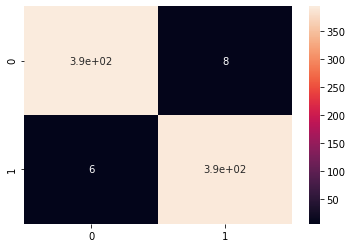

In [14]:
clf = LogisticRegression(C=1e5,max_iter = 300)
modelprid(clf,final_tr,final_te,result_trainn,result_test,"Lasso") # using lasso

Using Decision tree
0.9525
0 represents negative sentiment and 1 represents positive sentiment
Confusion matrix (row represents original result and col represents predicted results :-
   0     1
0 367 35
1 3 395

For Fake news:
precsion = 0.9918918918918919
recall =  0.9129353233830846
f1s =  0.9507772020725388

For True News:
precsion = 0.9186046511627907
recall =  0.992462311557789
f1s =  0.9541062801932367
Aver. Precision =  0.9552482715273413
Aver. recall =  0.9526988174704367
Aver. f1s =  0.9524417411328878

Time =  5.7199931144714355


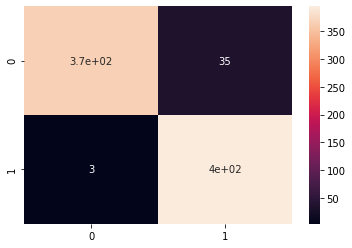

In [15]:
print("Using Decision tree")
modelprid(DecisionTreeClassifier(max_depth = 5),final_tr,final_te,result_trainn,result_test,"DT") # Using Decision tree

Using MLP model
0.98125
0 represents negative sentiment and 1 represents positive sentiment
Confusion matrix (row represents original result and col represents predicted results :-
   0     1
0 395 7
1 8 390

For Fake news:
precsion = 0.9801488833746899
recall =  0.9825870646766169
f1s =  0.9813664596273294

For True News:
precsion = 0.982367758186398
recall =  0.9798994974874372
f1s =  0.9811320754716981
Aver. Precision =  0.9812583207805439
Aver. recall =  0.9812432810820271
Aver. f1s =  0.9812492675495137

Time =  73.56746363639832


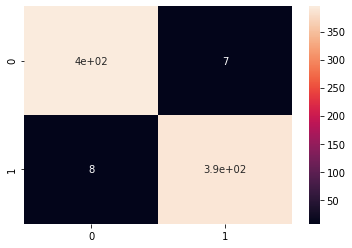

In [16]:
print("Using MLP model")
cl = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1,max_iter=5000)
modelprid(cl,final_tr,final_te,result_trainn,result_test,"MLPCV") # using MLP

In [17]:

print("\n\nPredicting Model using sentiment features ")



Predicting Model using sentiment features 


### Predicting Models using our sentiment features 

In [18]:
#print("SVC Model\n")
#modelprid(SVC(),score_trainn,score_testn,result_trainn,result_test) # Using SVR

Lasso Model

0.55
0 represents negative sentiment and 1 represents positive sentiment
Confusion matrix (row represents original result and col represents predicted results :-
   0     1
0 276 126
1 234 164

For Fake news:
precsion = 0.5411764705882353
recall =  0.6865671641791045
f1s =  0.6052631578947367

For True News:
precsion = 0.5655172413793104
recall =  0.4120603015075377
f1s =  0.47674418604651164
Aver. Precision =  0.5533468559837729
Aver. recall =  0.5493137328433211
Aver. f1s =  0.5410036719706242

Time =  0.5920073986053467


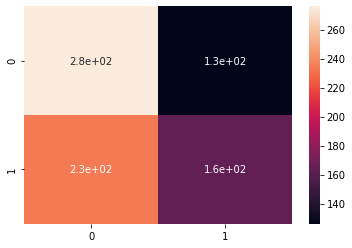

In [19]:
print("Lasso Model\n")
modelprid(clf,score_trainn,score_testn,result_trainn,result_test)   # Using lasso

Decision Tree Model

0.59875
0 represents negative sentiment and 1 represents positive sentiment
Confusion matrix (row represents original result and col represents predicted results :-
   0     1
0 272 130
1 191 207

For Fake news:
precsion = 0.5874730021598272
recall =  0.6766169154228856
f1s =  0.6289017341040463

For True News:
precsion = 0.6142433234421365
recall =  0.5201005025125628
f1s =  0.563265306122449
Aver. Precision =  0.6008581628009819
Aver. recall =  0.5983587089677243
Aver. f1s =  0.5960835201132476

Time =  0.7359933853149414


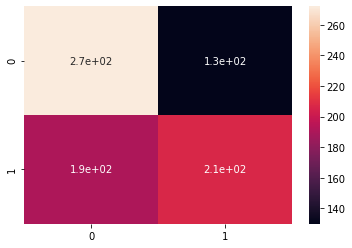

In [20]:
print("Decision Tree Model\n")

modelprid(DecisionTreeClassifier(max_depth = 5),score_trainn,score_testn,result_trainn,result_test)  # Using Decision Tree

Using MLP
0.4975
0 represents negative sentiment and 1 represents positive sentiment
Confusion matrix (row represents original result and col represents predicted results :-
   0     1
0 0 402
1 0 398

For Fake news:
Model is highly biased

Time =  0.4879932403564453


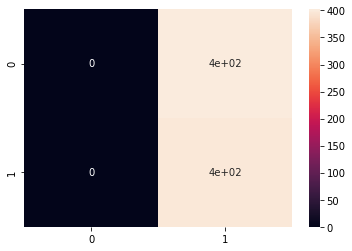

In [21]:
print("Using MLP")
modelprid(cl,score_trainn,score_testn,result_trainn,result_test)   # Using MLP

In [22]:
print("\n\nPredicting Model using N Gram + sentiment features ")



Predicting Model using N Gram + sentiment features 


### Predicting model by adding Ngrams and sentiment features

In [23]:


ccti = 6000

co_vect = CountVectorizer(ngram_range=(1,2))
final_tr  = co_vect.fit_transform(trainall2[:ccti])
final_te = co_vect.transform(trainall2[spl:])

feature_matrix1 = final_tr[:ccti].toarray()
score_trainnc = score_trainn[:ccti]
result_trainnc = result_trainn[:ccti]

feature_matrix2 = final_te[:ccti].toarray()      # Convert sparse to numpy

print("Concating all features....")
score_trainnn = np.concatenate(( feature_matrix1,score_trainnc), 1)  
score_testnn = np.concatenate((feature_matrix2,score_testn[:ccti]), 1)      # adds Ngram numpy and features matrix



Concating all features....


In [24]:
#print("SVR Model\n")
#modelprid(SVR(),score_trainnn,score_testnn,result_trainnc,result_test)  # Using SVR

Decision Tree Model

0.9275
0 represents negative sentiment and 1 represents positive sentiment
Confusion matrix (row represents original result and col represents predicted results :-
   0     1
0 345 57
1 1 397

For Fake news:
precsion = 0.9971098265895953
recall =  0.8582089552238806
f1s =  0.9224598930481284

For True News:
precsion = 0.8744493392070485
recall =  0.9974874371859297
f1s =  0.931924882629108
Aver. Precision =  0.935779582898322
Aver. recall =  0.9278481962049052
Aver. f1s =  0.9271923878386181

Time =  95.56130623817444


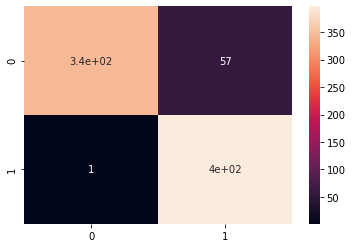

In [25]:
print("Decision Tree Model\n")

modelprid(DecisionTreeClassifier(max_depth = 5),score_trainnn,score_testnn,result_trainnc,result_test)  # Using Decision Tree 

Lasso Model

0.8475
0 represents negative sentiment and 1 represents positive sentiment
Confusion matrix (row represents original result and col represents predicted results :-
   0     1
0 314 88
1 34 364

For Fake news:
precsion = 0.9022988505747126
recall =  0.7810945273631841
f1s =  0.8373333333333333

For True News:
precsion = 0.8053097345132744
recall =  0.914572864321608
f1s =  0.8564705882352942
Aver. Precision =  0.8538042925439935
Aver. recall =  0.847833695842396
Aver. f1s =  0.8469019607843138

Time =  87.8791925907135


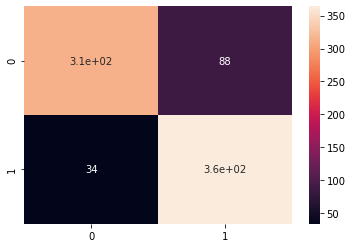

In [26]:
print("Lasso Model\n")

modelprid(clf,score_trainnn,score_testnn,result_trainnc,result_test)  # using lasso
   

Using MLP
0.4925
0 represents negative sentiment and 1 represents positive sentiment
Confusion matrix (row represents original result and col represents predicted results :-
   0     1
0 0 402
1 4 394

For Fake news:
Model is highly biased

Time =  3.6305899620056152


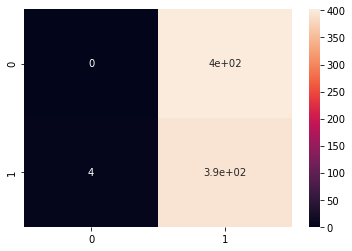

In [27]:
print("Using MLP")

modelprid(cl,score_trainnn,score_testnn,result_trainnc,result_test)  # using MLP
    